In [ ]:
import os
from itertools import combinations
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, gaussian_kde
import pickle
from matplotlib import rcParams, cycler
from matplotlib.cm import ScalarMappable
import cmasher as cmr
from sgcc import *

In [2]:
X = tf.convert_to_tensor([0.02,0.04,0.08,0.1,0.12,0.16,0.2,0.24,0.28,0.32], dtype = tf.float32)

In [ ]:
v1_xs_file = os.path.join("project_datafiles", "v1_ori_phase_condition_pcascores_wcomp.pkl")
v1_scores = pd.read_pickle(v1_xs_file)
v1_scores_condition_averaged = np.array([np.array(x) for x in v1_scores.scores.values]).mean(0)
Y_true = v1_scores_condition_averaged[:2,:,:].transpose(0,2,1)

In [4]:
Y_true = v1_scores_condition_averaged[:2,:,:].transpose(0,2,1)

In [5]:
param_bounds = {
    "fts": [20, 200],
    "t": [40, 100],
    "ats": [-3, 0],
    "a": [0.1, 4],
    "d": [10, 40],
    "inh_d": [0, 40],
    "inh_w": [0, 3],
}

In [6]:
with open(f'sgcc_mop_2_9_26.pkl', 'rb') as f:
    result = pickle.load(f)
params = result['final_epoch_params']

In [7]:
sgcc = SGCCircuit(param_bounds)

In [8]:
sgcc.load_saved_parameters(params)

In [9]:
predictions = sgcc.predict(X)

In [10]:
last_epoch_loss = result['loss_decay'][-1]
best = np.where(last_epoch_loss == last_epoch_loss.min())[0][0]

In [11]:
v1_neuron_1, v1_neuron_2 = v1_scores_condition_averaged[:2]

low_sf_1 = v1_neuron_1.T[0]
high_sf_1 = v1_neuron_1.T[-1]

low_sf_2 = v1_neuron_2.T[0]
high_sf_2 = v1_neuron_2.T[-1]

In [12]:
def vector_len(a: np.ndarray): 
    # calculate the length of a vector by calculating the square root of its self dot product
    
    return np.sqrt(np.dot(a, a))

def vector_angle(a: np.ndarray, b: np.ndarray, output_type = 'radians'): 
    # calculate the angle between two vectors
    
    dotab = np.dot(a,b)
    lena = vector_len(a)
    lenb = vector_len(b)
    prodab = lena*lenb
    
    # theta is the arccosine of the dotproduct of a & b
    # over the product of the lengths of a & b
    theta = np.arccos(dotab/prodab)
    
    output = {
        'radians': theta,
        'degrees': np.degrees(theta)
    }
    
    if output_type not in list(output.keys()):
        print("Error: please specify an output type of either 'radians' or 'degrees'")
    
    return output[output_type]

ang = []
dotprod = []
for t in range(250):
    ang.append(
        vector_angle(
            [low_sf_1[t], low_sf_2[t]],
            [high_sf_1[t], high_sf_2[t]],
            output_type = 'degrees'
        )
    )

    dotprod.append(
        np.dot(
            [low_sf_1[t], low_sf_2[t]],
            [high_sf_1[t], high_sf_2[t]],
        )
    )

ang = np.array(ang)
dotprod = np.array(dotprod)

In [13]:
t0 = np.where(dotprod[50:] == dotprod[50:].max())[0][0] + 50
t1 = np.where(ang[t0:150] == ang[t0:150].max())[0][0] + t0

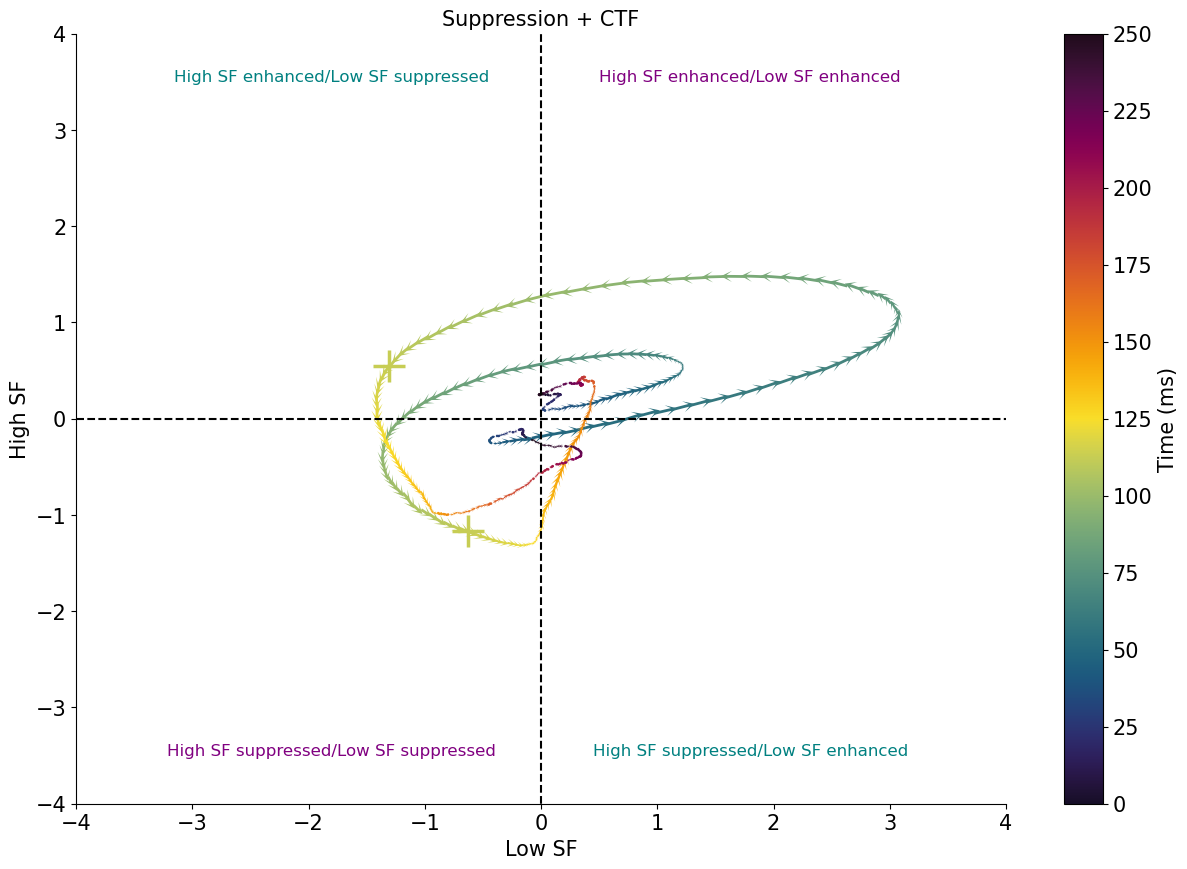

In [14]:
cmap = plt.get_cmap('cmr.pride')
norm = plt.Normalize(0, 250)
sm = ScalarMappable(cmap=cmap, norm=norm)
fig, ax = plt.subplots(figsize = (15, 10))

ax.set_xlabel('Low SF', fontsize = 15)
ax.set_ylabel('High SF', fontsize = 15)

width = 0.003
headwidth = 4
headaxislength = 2
headlength = 4
scale = 6

for t in range(250):

    ax.quiver(
        low_sf_1[t],
        high_sf_1[t],
        np.gradient(low_sf_1)[t],
        np.gradient(high_sf_1)[t],
        color = cmap((t+1)/250),
        width = width,
        headwidth = headwidth,
        headaxislength = headaxislength,
        headlength = headlength,
        scale = scale
    )
    ax.quiver(
        low_sf_2[t],
        high_sf_2[t],
        np.gradient(low_sf_2)[t],
        np.gradient(high_sf_2)[t],
        color = cmap((t+1)/250),
        width = width,
        headwidth = headwidth,
        headaxislength = headaxislength,
        headlength = headlength,
        scale = scale
    )

ax.scatter(
    low_sf_1[t1],
    high_sf_1[t1],
    marker = '+',
    color = cmap((t1+1)/250),
    s = 500,
    linewidths = 2.5
)
ax.scatter(
    low_sf_2[t1],
    high_sf_2[t1],
    marker = '+',
    color = cmap((t1+1)/250),
    s = 500,
    linewidths = 2.5
)


cbar = fig.colorbar(sm, ax=ax, label = 'Time (ms)')
cbar.set_label('Time (ms)', fontsize = 15)
cbar.set_ticks(np.arange(0,275,25))
plt.tick_params(labelsize = 15)
cbar.ax.tick_params(labelsize = 15)

t = t1
v_l_v1 = np.array([low_sf_1[t], low_sf_2[t]])
v_h_v1 = np.array([high_sf_1[t], high_sf_2[t]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(np.linspace(-6,6,250), [0]*250, '--', color = 'black')
ax.plot([0]*250, np.linspace(-6,6,250), '--', color = 'black')
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)

ax.text(
    -1.8,3.5, 
    'High SF enhanced/Low SF suppressed', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'teal'
)

ax.text(
    1.8,3.5, 
    'High SF enhanced/Low SF enhanced', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'purple'
)

ax.text(
    -1.8,-3.5, 
    'High SF suppressed/Low SF suppressed', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'purple'
)

ax.text(
    1.8,-3.5, 
    'High SF suppressed/Low SF enhanced', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'teal'
)

ax.set_title("Suppression + CTF", fontsize = 15)

fig.subplots_adjust(wspace=0.1)

In [15]:
v1_neuron_1, v1_neuron_2 = predictions[best]

In [16]:
low_sf_1 = v1_neuron_1[0]
high_sf_1 = v1_neuron_1[-1]

low_sf_2 = v1_neuron_2[0]
high_sf_2 = v1_neuron_2[-1]

In [17]:
ang = []
dotprod = []
for t in range(250):
    ang.append(
        vector_angle(
            [low_sf_1[t], low_sf_2[t]],
            [high_sf_1[t], high_sf_2[t]],
            output_type = 'degrees'
        )
    )

    dotprod.append(
        np.dot(
            [low_sf_1[t], low_sf_2[t]],
            [high_sf_1[t], high_sf_2[t]],
        )
    )

ang = np.array(ang)
dotprod = np.array(dotprod)

In [18]:
t0 = np.where(dotprod[50:] == dotprod[50:].max())[0][0] + 50
t1 = np.where(ang[t0:] == ang[t0:]. max())[0][0] + t0

Text(0, 0.5, 'Au')

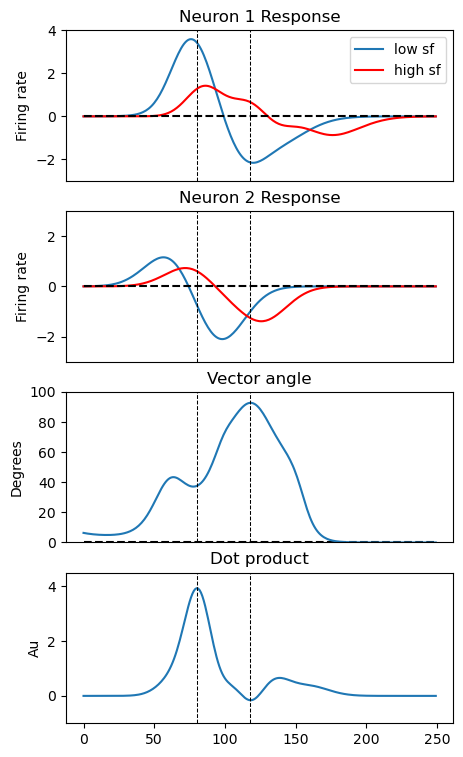

In [19]:
fig, ax = plt.subplots(4, figsize = (5,9))
ax[0].plot(low_sf_1, label = 'low sf')
ax[0].plot(high_sf_1, color = 'red', label = 'high sf')
ax[0].plot([t0]*250, np.linspace(-3,4,250), '--', color = 'black', linewidth = 0.75)
ax[0].plot([t1]*250, np.linspace(-3,4,250), '--', color = 'black', linewidth = 0.75)
ax[0].set_ylim(-3, 4)
ax[0].set_title("Neuron 1 Response")
ax[0].set_ylabel("Firing rate")
ax[0].legend()

ax[1].plot(low_sf_2)
ax[1].plot(high_sf_2, color = 'red')
ax[1].plot([t0]*250, np.linspace(-3,3,250), '--', color = 'black', linewidth = 0.75)
ax[1].plot([t1]*250, np.linspace(-3,3,250), '--', color = 'black', linewidth = 0.75)
ax[1].set_ylim(-3, 3)
ax[1].set_title("Neuron 2 Response")
ax[1].set_ylabel("Firing rate")

for i in range(3):
    ax[i].plot(np.zeros(250), '--', color = 'black')
    if i < 3:
        ax[i].set_xticks([])

ax[2].plot(ang)
ax[2].plot([t0]*250, np.linspace(0,100,250), '--', color = 'black', linewidth = 0.75)
ax[2].plot([t1]*250, np.linspace(0,100,250), '--', color = 'black', linewidth = 0.75)
ax[2].set_ylim(0, 100)
ax[2].set_title("Vector angle")
ax[2].set_ylabel("Degrees")

ax[3].plot(dotprod)
ax[3].plot([t0]*250, np.linspace(-1,4.5,250), '--', color = 'black', linewidth = 0.75)
ax[3].plot([t1]*250, np.linspace(-1,4.5,250), '--', color = 'black', linewidth = 0.75)
ax[3].set_ylim(-1, 4.5)
ax[3].set_title("Dot product")
ax[3].set_ylabel("Au")

In [20]:
import cmasher as cmr

In [21]:
v1_scores_condition_averaged.shape

(259, 250, 10)

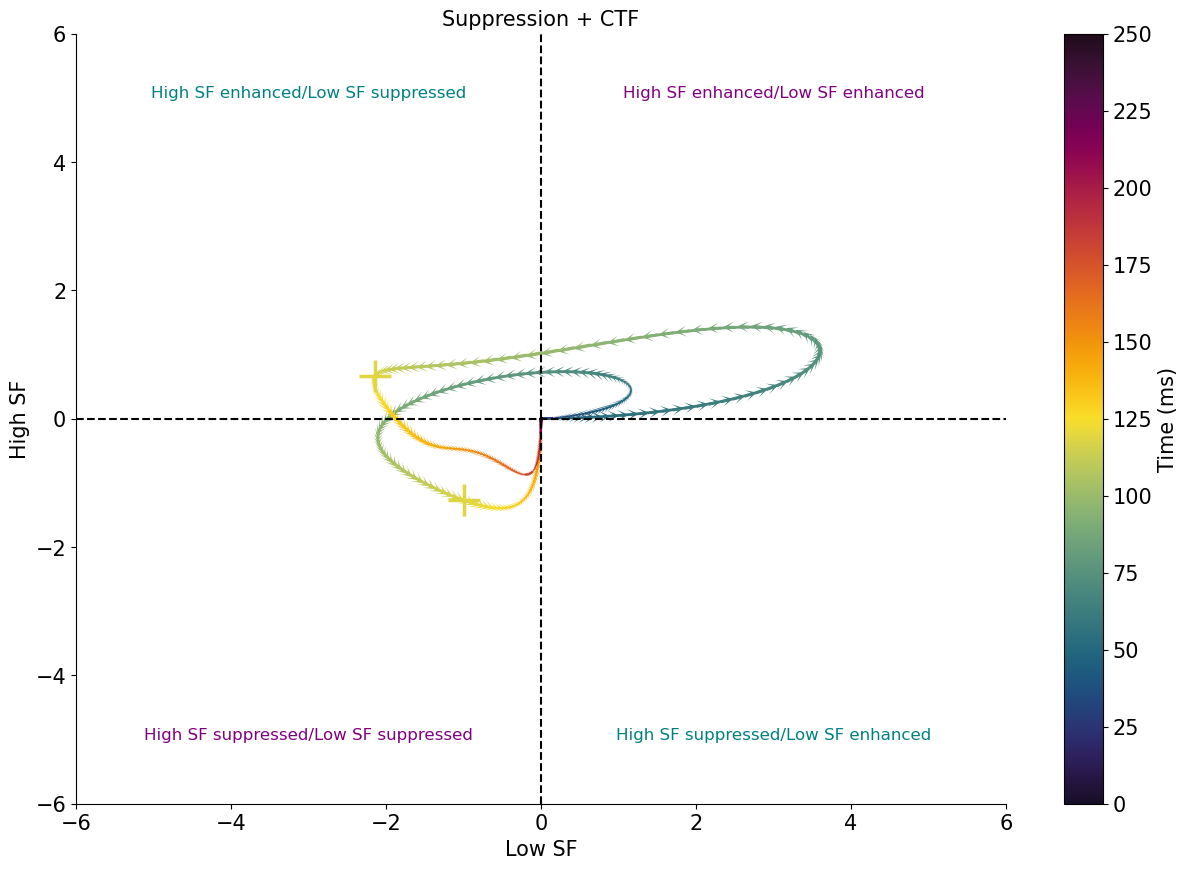

In [22]:
cmap = plt.get_cmap('cmr.pride')
norm = plt.Normalize(0, 250)
sm = ScalarMappable(cmap=cmap, norm=norm)
fig, ax = plt.subplots(figsize = (15, 10))

ax.set_xlabel('Low SF', fontsize = 15)
ax.set_ylabel('High SF', fontsize = 15)

width = 0.003
headwidth = 4
headaxislength = 2
headlength = 4
scale = 6

for t in range(250):

    ax.quiver(
        low_sf_1[t],
        high_sf_1[t],
        np.gradient(low_sf_1)[t],
        np.gradient(high_sf_1)[t],
        color = cmap((t+1)/250),
        width = width,
        headwidth = headwidth,
        headaxislength = headaxislength,
        headlength = headlength,
        scale = scale
    )
    ax.quiver(
        low_sf_2[t],
        high_sf_2[t],
        np.gradient(low_sf_2)[t],
        np.gradient(high_sf_2)[t],
        color = cmap((t+1)/250),
        width = width,
        headwidth = headwidth,
        headaxislength = headaxislength,
        headlength = headlength,
        scale = scale
    )

ax.scatter(
    low_sf_1[t1],
    high_sf_1[t1],
    marker = '+',
    color = cmap((t1+1)/250),
    s = 500,
    linewidths = 2.5
)
ax.scatter(
    low_sf_2[t1],
    high_sf_2[t1],
    marker = '+',
    color = cmap((t1+1)/250),
    s = 500,
    linewidths = 2.5
)


cbar = fig.colorbar(sm, ax=ax, label = 'Time (ms)')
cbar.set_label('Time (ms)', fontsize = 15)
cbar.set_ticks(np.arange(0,275,25))
plt.tick_params(labelsize = 15)
cbar.ax.tick_params(labelsize = 15)

t = t1
v_l_v1 = np.array([low_sf_1.numpy()[t], low_sf_2.numpy()[t]])
v_h_v1 = np.array([high_sf_1[t].numpy(), high_sf_2.numpy()[t]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(np.linspace(-6,6,250), [0]*250, '--', color = 'black')
ax.plot([0]*250, np.linspace(-6,6,250), '--', color = 'black')
ax.set_ylim(-6,6)
ax.set_xlim(-6,6)

ax.text(
    -3,5, 
    'High SF enhanced/Low SF suppressed', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'teal'
)

ax.text(
    3,5, 
    'High SF enhanced/Low SF enhanced', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'purple'
)

ax.text(
    -3,-5, 
    'High SF suppressed/Low SF suppressed', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'purple'
)

ax.text(
    3,-5, 
    'High SF suppressed/Low SF enhanced', 
    horizontalalignment = 'center',
    fontsize = 12,
    color = 'teal'
)

ax.set_title("Suppression + CTF", fontsize = 15)

fig.subplots_adjust(wspace=0.1)

In [23]:
from itertools import combinations
from scipy import stats

In [24]:
def pairwise_vector_correlations(population_resp, sfs):
    sf_combos = list(combinations(sfs, 2)) # list of comparisons of each unique SF condition
    sf_combo_idx = list(combinations(np.arange(len(sfs)),2)) # index wise comparisons of the SF conditions
    sf_octave_diff = np.array([np.log2(x[1]/x[0]) for x in sf_combos]) # octave difference of each SF comparison
    sf_diff_idx = np.argsort(sf_octave_diff) # combo index sorted from lowest to highest octave difference

    corr = np.zeros((sf_diff_idx.shape[0], 250))
    for i, comp in enumerate(sf_combo_idx):
        for t in range(250):
            corr[i, t] = vector_angle(population_resp[comp[0],t,:], 
            population_resp[comp[1],t,:], 'radians')
    corr = corr[sf_diff_idx]

    return corr

In [25]:
resp = predictions[best][:2].numpy().transpose(1,2,0)

In [26]:
def calculate_sign_sum(X):
    ## Calculate enhancement and suppression sums over time
    nunit, T, nsf = X.shape
    exc_timecourse = np.zeros((T, nsf))
    sup_timecourse = np.zeros((T, nsf))
    for t in range(T):
        for sf in range(nsf):
            exc = X[:,t,sf][X[:,t,sf] > 0].sum()
            sup = X[:,t,sf][X[:,t,sf] < 0].sum()
            exc_timecourse[t,sf] = exc
            sup_timecourse[t,sf] = sup
                
    return exc_timecourse, sup_timecourse

def calculate_esi(exc, sup):
    return (
        (exc - np.abs(sup))
        / (np.abs(sup) + exc)
    ) 

def calculate_desi(esi, return_average = True):
    sf_i = np.arange(0,10)
    comparisons = list(combinations(sf_i, 2))
    
    si_distance = np.zeros((45, 250))

    for i, c in enumerate(comparisons):
        distance = np.abs(esi.T[c[0]] - esi.T[c[1]])
        si_distance[i,:] = distance

    return si_distance

In [27]:
def desi_corr(sample):
    predictions = sgcc.predict(X)
    resp = predictions[sample][:2].numpy().transpose(1,2,0)
    corr = pairwise_vector_correlations(resp, X.numpy())

    exc, sup = calculate_sign_sum(resp.transpose(2,1,0))
    esi = calculate_esi(exc, sup)
    desi = calculate_desi(esi)

    sf_combos = list(combinations(X, 2)) # list of comparisons of each unique SF condition
    sf_combo_idx = list(combinations(np.arange(len(X)),2)) # index wise comparisons of the SF conditions
    sf_octave_diff = np.array([np.log2(x[1]/x[0]) for x in sf_combos]) # octave difference of each SF comparison
    sf_diff_idx = np.argsort(sf_octave_diff) # combo index sorted from lowest to highest octave difference
    corr[np.where(np.isnan(corr))] = 0

    return corr, desi[sf_diff_idx]

C:\Users\Sturdy\AppData\Local\Temp\ipykernel_21860\1226483008.py:16: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(dotab/prodab)


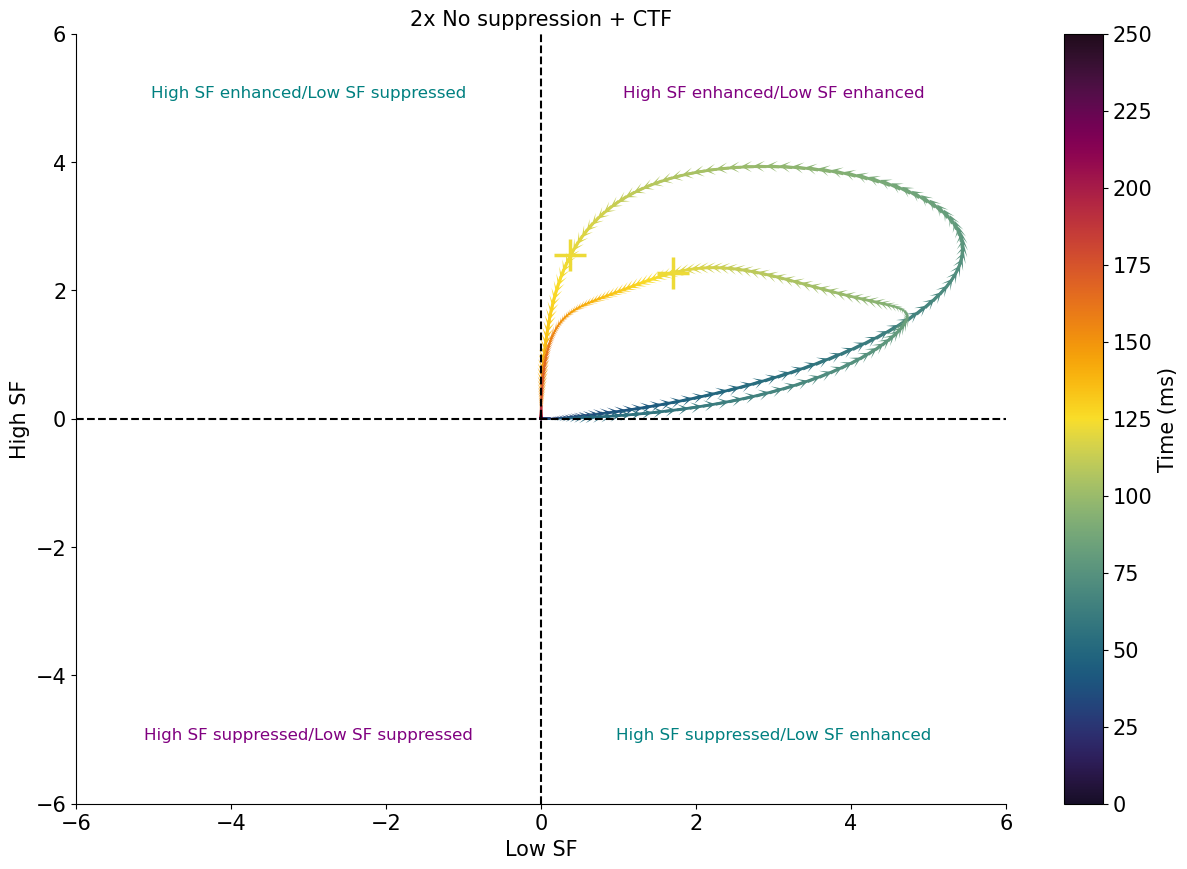

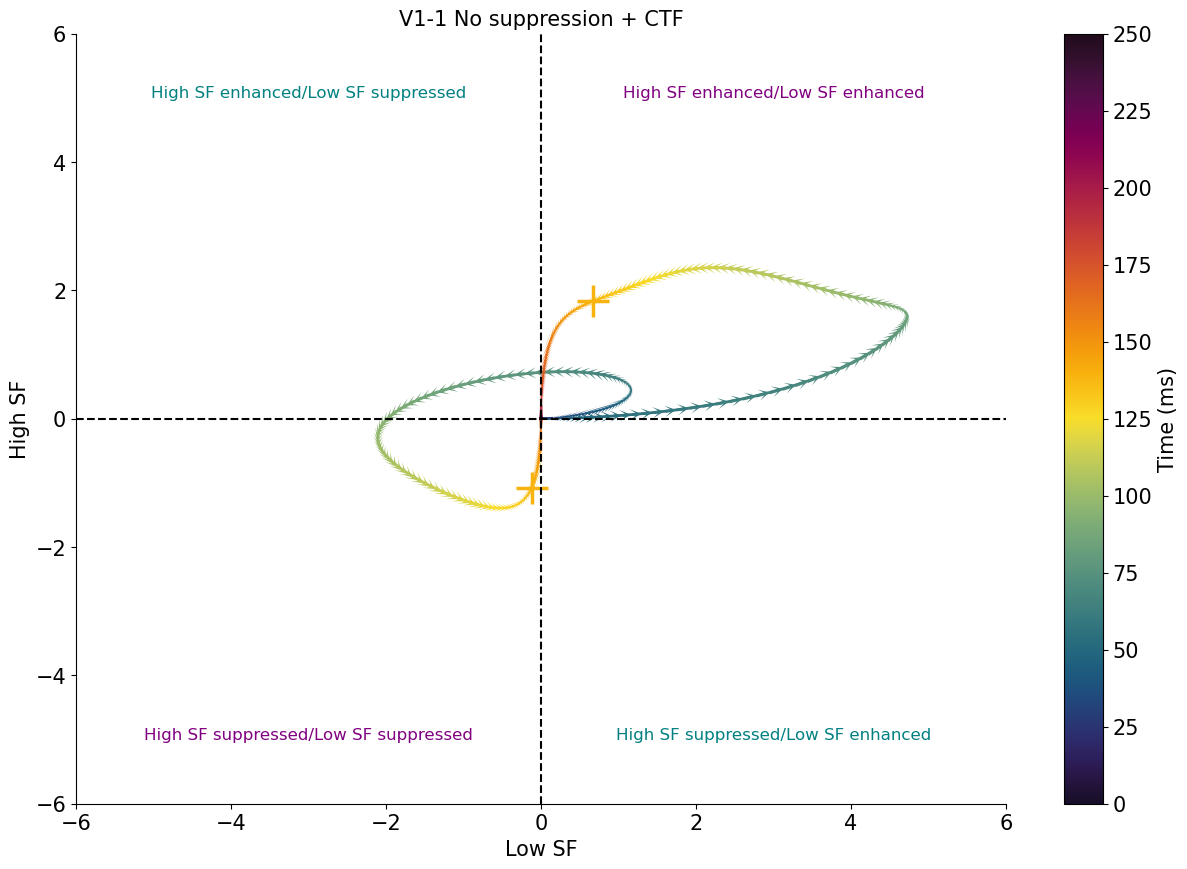

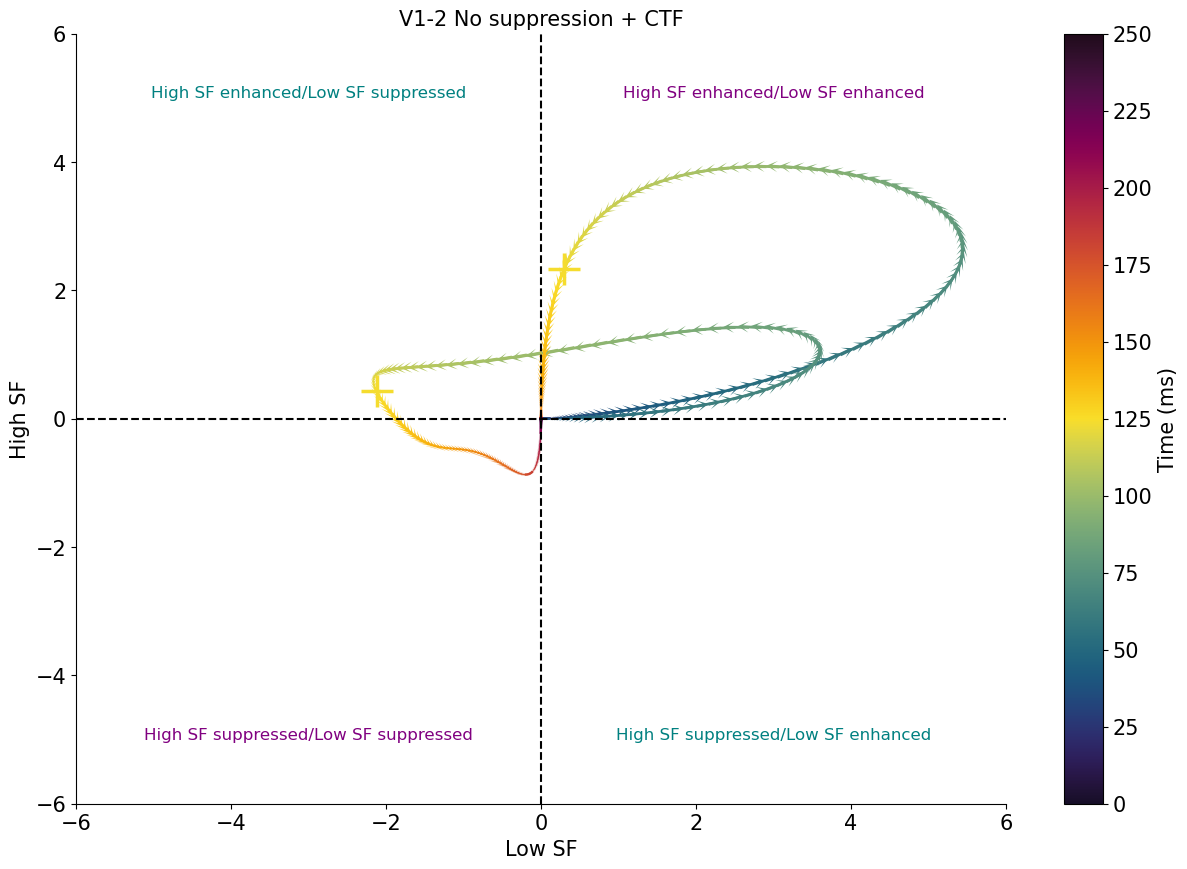

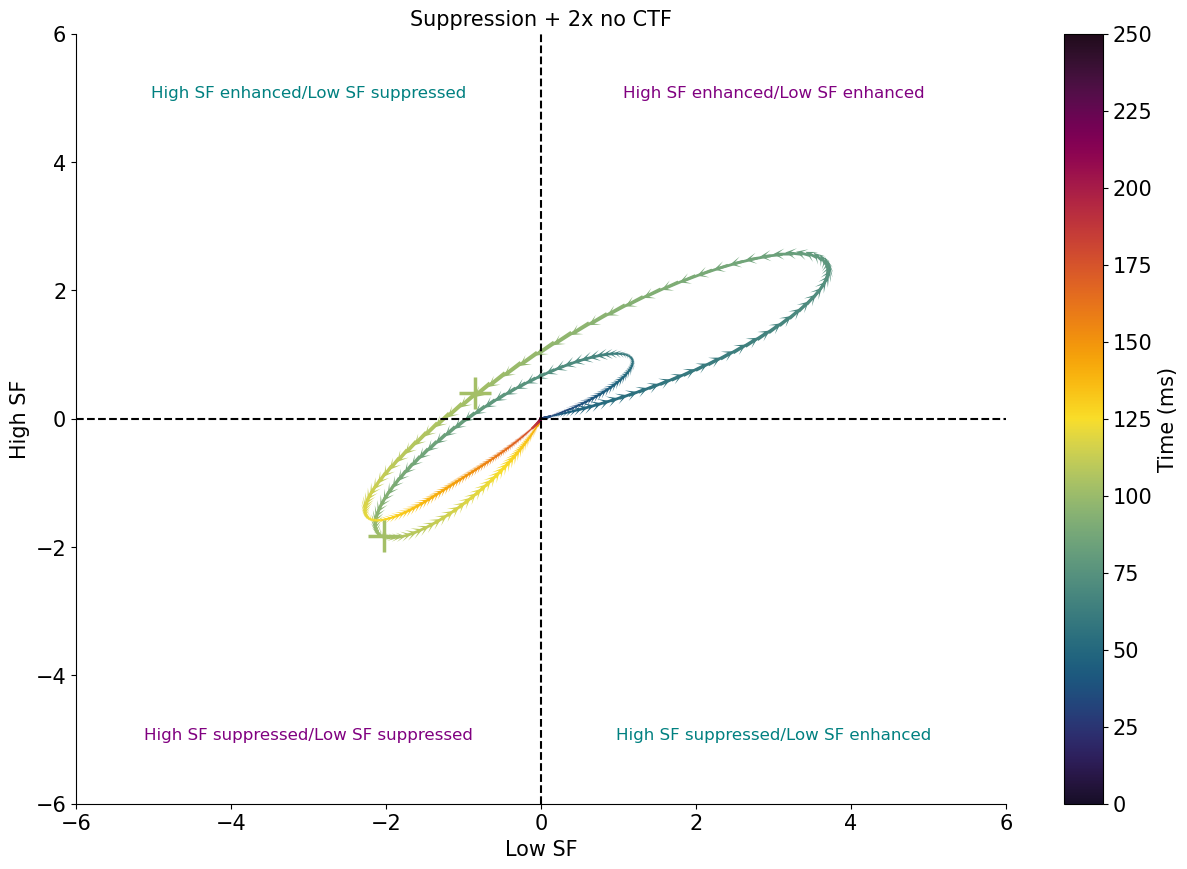

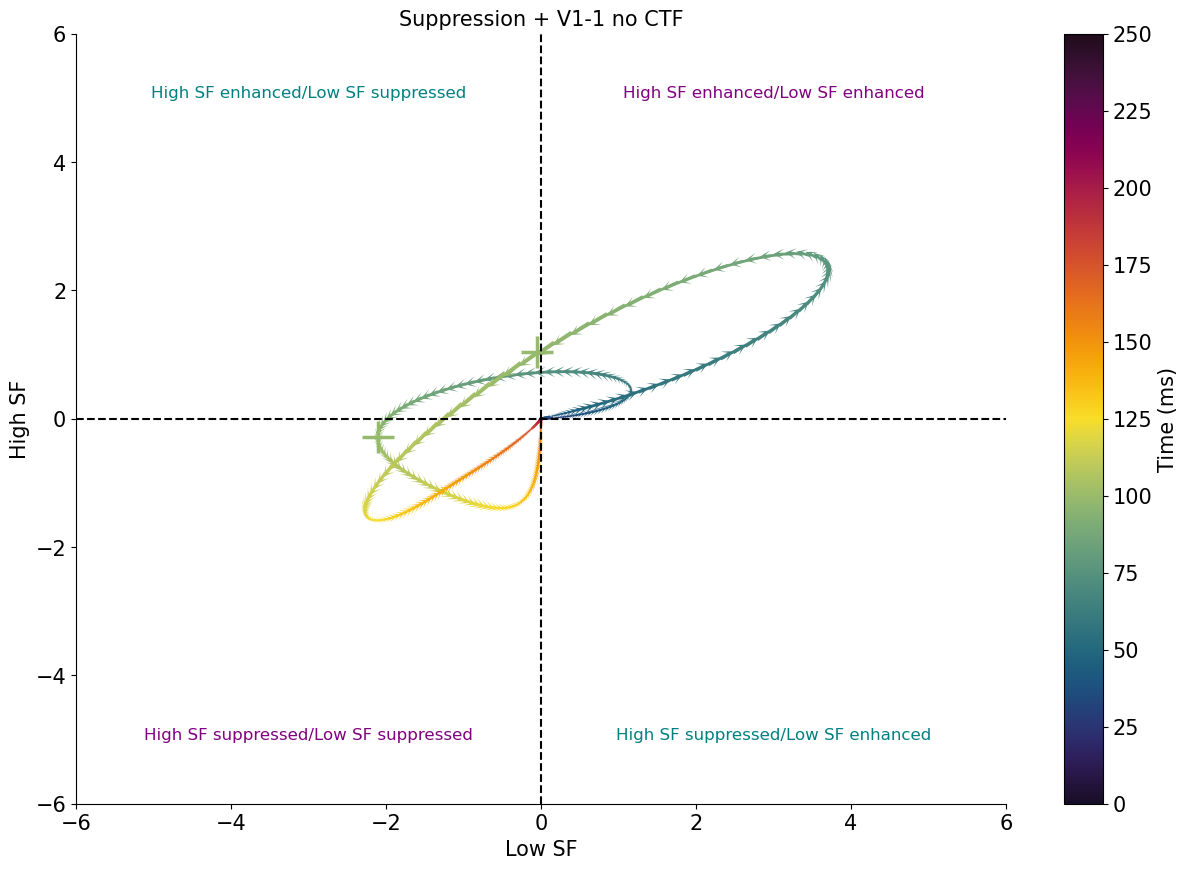

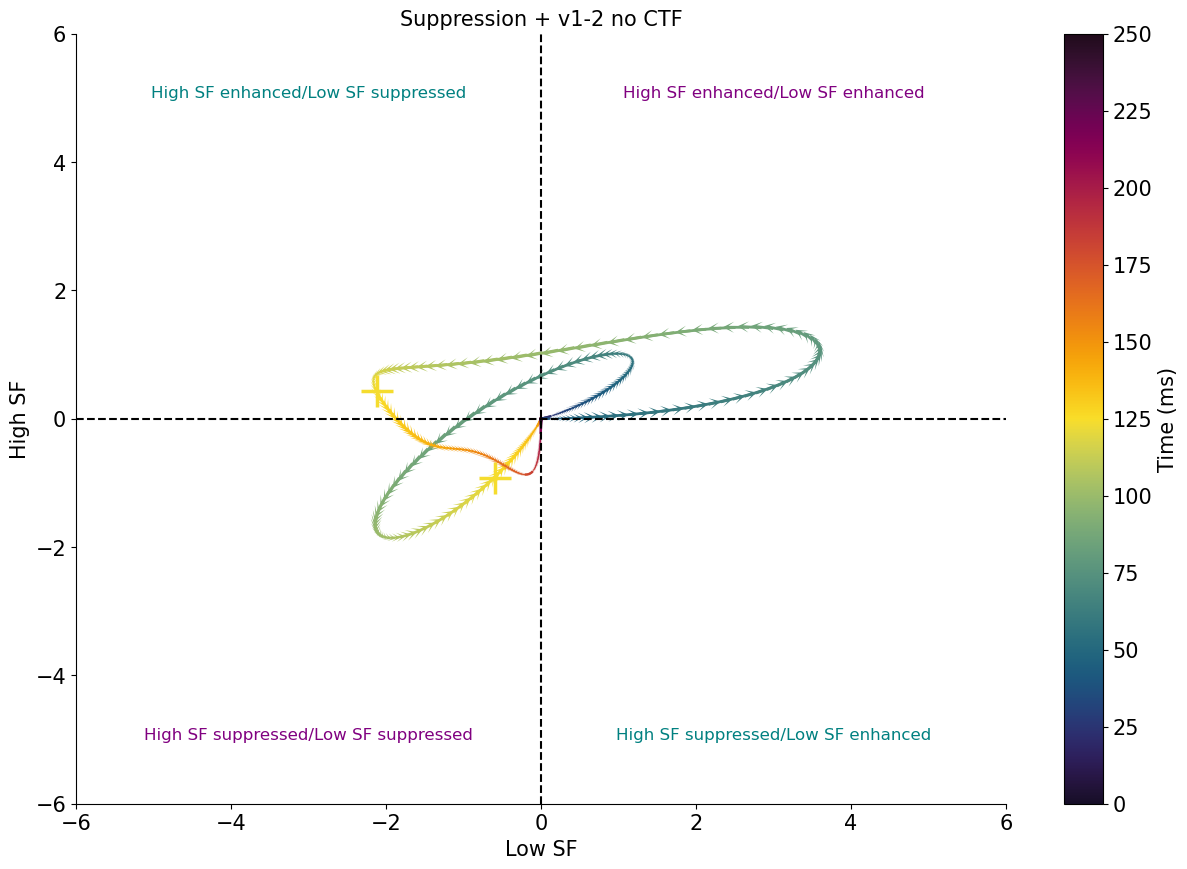

In [28]:
sgcc = SGCCircuit(param_bounds)
sgcc.load_saved_parameters(params)
corr, desi = desi_corr(best)

width = 0.003
headwidth = 4
headaxislength = 2
headlength = 4
scale = 6

labels = [
    'Suppression + CTF',
    '2x No suppression + CTF',
    'V1-1 No suppression + CTF',
    'V1-2 No suppression + CTF',
    'Suppression + 2x no CTF',
    'Suppression + V1-1 no CTF',
    'Suppression + v1-2 no CTF'
]

conditions = [
    ['V1', [best], [None], [0,1], 'inh_w', 0],
    ['V1', [best], [None], [0], 'inh_w', 0],
    ['V1', [best], [None], [1], 'inh_w', 0],
    ['dLGN', [best], [0,1,2], [0,1], 'fts', 21],
    ['dLGN', [best], [0,1,2], [0], 'fts', 21],
    ['dLGN', [best], [0,1,2], [1], 'fts', 21],
]

cmap = plt.get_cmap('cmr.pride')
norm = plt.Normalize(0, 250)
sm = ScalarMappable(cmap=cmap, norm=norm)

for i, cond in enumerate(conditions):

    sgcc.set_parameter(*cond)
    corr, desi = desi_corr(best)
    predictions = sgcc.predict(X)
    v1_neuron_1, v1_neuron_2 = predictions[best]
    
    low_sf_1 = v1_neuron_1[0]
    high_sf_1 = v1_neuron_1[-1]

    low_sf_2 = v1_neuron_2[0]
    high_sf_2 = v1_neuron_2[-1]

    ang = []
    dotprod = []
    for t in range(250):
        ang.append(
            vector_angle(
                [low_sf_1[t], low_sf_2[t]],
                [high_sf_1[t], high_sf_2[t]],
                output_type = 'degrees'
            )
        )

        dotprod.append(
            np.dot(
                [low_sf_1[t], low_sf_2[t]],
                [high_sf_1[t], high_sf_2[t]],
            )
        )

    ang = np.array(ang)
    ang[np.where(np.isnan(ang))] = 0
    dotprod = np.array(dotprod)
    t0 = np.where(dotprod[50:] == dotprod[50:].max())[0][0] + 50
    t1 = np.where(ang[t0:] == ang[t0:]. max())[0][0] + t0

    fig, ax = plt.subplots(figsize = (15, 10))

    ax.set_xlabel('Low SF', fontsize = 15)
    ax.set_ylabel('High SF', fontsize = 15)

    for t in range(250):

        ax.quiver(
            low_sf_1[t],
            high_sf_1[t],
            np.gradient(low_sf_1)[t],
            np.gradient(high_sf_1)[t],
            color = cmap((t+1)/250),
            width = width,
            headwidth = headwidth,
            headaxislength = headaxislength,
            headlength = headlength,
            scale = scale
        )
        ax.quiver(
            low_sf_2[t],
            high_sf_2[t],
            np.gradient(low_sf_2)[t],
            np.gradient(high_sf_2)[t],
            color = cmap((t+1)/250),
            width = width,
            headwidth = headwidth,
            headaxislength = headaxislength,
            headlength = headlength,
            scale = scale
        )

    ax.scatter(
        low_sf_1[t1],
        high_sf_1[t1],
        marker = '+',
        color = cmap((t1+1)/250),
        s = 500,
        linewidths = 2.5
    )
    ax.scatter(
        low_sf_2[t1],
        high_sf_2[t1],
        marker = '+',
        color = cmap((t1+1)/250),
        s = 500,
        linewidths = 2.5
    )

    cbar = fig.colorbar(sm, ax=ax, label = 'Time (ms)')
    cbar.set_label('Time (ms)', fontsize = 15)
    cbar.set_ticks(np.arange(0,275,25))
    plt.tick_params(labelsize = 15)
    cbar.ax.tick_params(labelsize = 15)

    t = t1
    v_l_v1 = np.array([low_sf_1.numpy()[t], low_sf_2.numpy()[t]])
    v_h_v1 = np.array([high_sf_1[t].numpy(), high_sf_2.numpy()[t]])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot(np.linspace(-6,6,250), [0]*250, '--', color = 'black')
    ax.plot([0]*250, np.linspace(-6,6,250), '--', color = 'black')
    
    ax.set_ylim(-6,6)
    ax.set_xlim(-6,6)
    
    ax.text(
        -3,5, 
        'High SF enhanced/Low SF suppressed', 
        horizontalalignment = 'center',
        fontsize = 12,
        color = 'teal'
    )

    ax.text(
        3,5, 
        'High SF enhanced/Low SF enhanced', 
        horizontalalignment = 'center',
        fontsize = 12,
        color = 'purple'
    )

    ax.text(
        -3,-5, 
        'High SF suppressed/Low SF suppressed', 
        horizontalalignment = 'center',
        fontsize = 12,
        color = 'purple'
    )

    ax.text(
        3,-5, 
        'High SF suppressed/Low SF enhanced', 
        horizontalalignment = 'center',
        fontsize = 12,
        color = 'teal'
    )

    fig.subplots_adjust(wspace=0.1)
    ax.set_title(labels[i+1], fontsize = 15)
    sgcc = SGCCircuit(param_bounds)
    sgcc.load_saved_parameters(params)